# NBA All-Star Classifier - Modelling

## Outlier Addressing and Preprocessing

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE

from xgboost import XGBClassifier as XGBC
import shap
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, log_loss, plot_confusion_matrix

import os.path
import pickle

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use('dark_background')

# check if this is our first time running the script
# if the model exists from a prior execution, we can load the model from memory instead of retraining it from scratch
already_trained = os.path.exists('./ASG_predictor.model')

# directory to store plots concerning model evaluation and interpretation
if not os.path.exists('./Plots'):
    os.makedirs('./Plots')

# labeled dataset
df_train = pd.read_csv('ASG_train.csv')

# current year's dataset (unlabeled)
df_to_predict = pd.read_csv('ASG_to_predict.csv')

# pull out the current season from the df for file naming purposes
prediction_year = df_to_predict.loc[0, 'Year'] + 1

# save the PLAYER and TEAM columns for later
# these features get dropped during the prediction process but we will add them back in later
names_and_teams = df_to_predict[['PLAYER', 'TEAM']]

# manually purging some outliers that are polluting the training data
# (since the dataset is small and our SME is high, this can be done manually - otherwise
# we would perform some automated method like Tukey outlier detection)
#
# these players fall into either one or both of the follwing two cases:
#   A: had long, illustrious careers and were selected in their twilight years as a sort of "farewell",
#      despite not playing at an All-Star level
#   B: sat out way too many games of this season and were only selected due to overpowering clout/fan 
#      favouritism
#
# Note: 'Year' in our dataset refers to the calandar year in which the season started, so the ASG in question 
#       will be equal to 'Year'+1
outliers = set([
    ('Dirk Nowitzki', 2018), # A: Dirk's selection in the 2019 ASG was very much a "respect" pick - career tribute
    ('Kobe Bryant', 2015), # A
    ('Kobe Bryant', 2013), # A/B
    ('Yao Ming', 2010), # B: had all of China rallying for him despite playing in only 5 out of a possible 44 games (11.3%)
    ('Allen Iverson', 2009), # A
    ('Allen Iverson', 2008), # A
    ("Shaquille O'Neal", 2006), # A/B
    ('Ray Allen', 2003), # B
    ('Jamaal Magloire', 2003), # infamously questionable pick
    ('Vince Carter', 2002), # B
    ('Grant Hill', 2000), # B
    ('Anfernee Hardaway', 1997), #A/B
    ('Anfernee Hardaway', 1996) #A/B
])

# stores the indices of our outliers
outlier_indices = []

# gather outlier indices
def process_outliers(row):
    if (row['PLAYER'], row['Year']) in outliers:
        outlier_indices.append(row.name)

# reject the outliers
df_train[['PLAYER', 'Year']].apply(process_outliers, axis=1)
df_train.drop(outlier_indices, inplace=True)

for df in [df_train, df_to_predict]:
    # drop any player who appeared in less than 7 games 
    df.drop(df[df['GP'] < 7].index, inplace=True)

    # the % of team's games the player played in
    df['Play Pct.'] = df['GP'] / df['Team GP']

    # nomalized via league average pace for that year
    for col in ['PTS', 'REB', 'AST', 'STL', 'BLK', 'TOV', '3PM']:
        df['Adjusted ' + col] = df[col] / df['Avg. Pace']

# final features used for this model
#
# features that have been commented out indicated negligible predictive power in earlier models
# and have been stripped in the final version
features = [
    'Adjusted PTS',
    'Adjusted REB',
    'Adjusted AST',
    #'Adjusted STL',
    'Adjusted BLK',
    #'Adjusted TOV',
    #'Adjusted 3PM',
    'DEFWS',
    #'TS%',
    'USG%',
    'PIE',
    'Play Pct.',
    'Team Conference Rank',
    'Prior ASG Appearances',
    #'AS Last Year?'
]

## Partitioning Labeled Dataset

In [32]:
# split labeled data into 66% train, 17% validation, 17% test
train, non_train = train_test_split(df_train, train_size=0.66, stratify=df_train['Selected?'], shuffle=True, random_state=0)
validation, test = train_test_split(non_train, train_size=0.5, stratify=non_train['Selected?'], shuffle=True, random_state=0)

X_train, y_train = train[features], train['Selected?']
X_val, y_val = validation[features], validation['Selected?']
X_test, y_test = test[features], test['Selected?']

df_to_predict = df_to_predict[features]

tuned_model = None

## Tuning XGBoost Hyperparameters

In [ ]:
# performed only during first execution for model tuning purposes - trains the model
if not already_trained:

    #print(y_train.value_counts())
    #
    # we use SMOTE (synthetic minority oversampling technique) to balance out our output classes
    #
    # in our training data, there are 5409 non all-stars and only 368 all-stars, so a crude blanket strategy labelling
    # everyone as a non-all star would still achieve 93.6% accuracy
    #
    # SMOTE will create synthetic data points in the all-star class so that the classes are balanced
    X_train_oversampled, y_train_oversampled = BorderlineSMOTE(random_state=0).fit_sample(X_train, y_train)

    # range of learning rates we will consider
    learning_rates = [a * (10**b) for b in range(-6, -1) for a in range(1, 10)] + [0.1]

    # maximum number of rounds we will consider
    max_n_estimators = 2500
    # number of rounds after which to terminate the process if no improvement is seen
    early_stopping_rounds = 10
    # maximum depth of the decision tree - kept very low to avoid overfitting and ensure a relatively "simple" model
    max_depth = 2

    best_learning_rate, best_ntree_limit = learning_rates[0], 1
    highest_auc = -float('inf')

    for learning_rate in learning_rates:

        model = XGBC(objective='binary:logistic', learning_rate=learning_rate,
                     n_estimators=max_n_estimators, max_depth=max_depth, n_jobs=-1, random_state=0)
        model.fit(X=X_train_oversampled, y=y_train_oversampled, eval_metric=['error', 'logloss', 'auc'],
                  eval_set=[(X_train_oversampled, y_train_oversampled), (X_val, y_val)],
                  early_stopping_rounds=early_stopping_rounds, verbose=True)
        curr_auc = max(model.evals_result()['validation_1']['auc']) # AUC of the validation set
        if curr_auc > highest_auc:
            highest_auc, best_learning_rate, best_ntree_limit = curr_auc, learning_rate, model.best_ntree_limit

    # train the model with the optimal hyperparameters
    tuned_model = XGBC(objective='binary:logistic', learning_rate=best_learning_rate, n_estimators=best_ntree_limit,
                       max_depth=max_depth, n_jobs=-1, random_state=0)
    tuned_model.fit(X=X_train_oversampled, y=y_train_oversampled, eval_metric=['error', 'logloss', 'auc'],
                    eval_set=[(X_train_oversampled, y_train_oversampled), (X_val, y_val)],
                    early_stopping_rounds=early_stopping_rounds, verbose=True)

    # serialize the model and export to local memory
    pickle.dump(tuned_model, open('ASG_predictor.model', 'wb'))

In [34]:
tuned_model = pickle.load(open('ASG_predictor.model', 'rb'))

# run the tuned model on the test set and get all-star prediction probabilities
y_test_proba = [prob[1] for prob in tuned_model.predict_proba(X_test)]

# shows model performance progress during training and how it fares with the test set
def show_model_evaluations():

    results = tuned_model.evals_result()
    epochs = len(results['validation_0']['auc'])
    x_axis = range(0, epochs)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x_axis, results['validation_0']['auc'], label='Train')
    ax.plot(x_axis, results['validation_1']['auc'], label='Validation')
    plt.title('XGBoost AUC ({} epochs)'.format(epochs))
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    ax.legend()
    plt.savefig('./Plots/AUC-training.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Validation')
    plt.title('XGBoost Error% ({} epochs)'.format(epochs))
    plt.xlabel('Epoch')
    plt.ylabel('Error%')
    ax.legend()
    plt.savefig('./Plots/error-training.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Validation')
    plt.title('XGBoost Logarithmic Loss ({} epochs)'.format(epochs))
    plt.xlabel('Epoch')
    plt.ylabel('Log. Loss')
    ax.legend()
    plt.savefig('./Plots/logloss-training.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(8,8))
    plot_confusion_matrix(tuned_model, X_test, y_test, cmap= plt.cm.bone,
                          display_labels=['Not AS', 'All Star'], normalize='true', ax=ax)
    plt.title('Normalized confusion matrix\n')
    plt.savefig('./Plots/confusion.png')
    plt.show()

    fig, ax = plt.subplots(figsize=(8,8))
    fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
    no_skill = [0] * len(y_test)
    fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_test, no_skill)
    ax.plot(fpr, tpr, label='XGBoost')
    ax.plot(fpr_ns, tpr_ns, linestyle='--', label='No Skill')
    plt.title('XGBoost ROC Curve\n(AUC = {:.4f})'.format(roc_auc_score(y_test, y_test_proba)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.savefig('./Plots/ROCAUC.png')
    ax.legend()
    plt.show()


def show_model_interpretation():

    # uses SHAP values to "explain" the model robustly
    # SHAP provides model inteprtation metrics that are accurate and consistent (unlike gain, cover or weight)
    shap_values = shap.TreeExplainer(tuned_model).shap_values(X_train)

    shap.summary_plot(shap_values, X_train, plot_type='dot', axis_color='#FFFFFF', plot_size=(12,8), show=False)
    plt.subplots_adjust(left=0.3)
    plt.title('Model SHAP Details')
    plt.savefig('./Plots/SHAP-Details.png')
    plt.show()
    
    shap.summary_plot(shap_values, X_train, plot_type='bar', color='#00cccc', axis_color='#FFFFFF',
                      plot_size=(12,8), show=False)
    plt.subplots_adjust(left=0.22)
    plt.title('Model SHAP Summary')
    plt.savefig('./Plots/SHAP-Summary.png')
    plt.show()


def show_classification_metrics():

    # range of classification thresholds to consider
    thresholds = np.arange(0.1, 1, 0.0025)

    highest_f1_score = -float('inf')
    optimal_threshold = thresholds[0]
    for threshold in thresholds:
        y_pred = [0 if prob < threshold else 1 for prob in y_test_proba]
        curr_f1_score = f1_score(y_test, y_pred)
        if curr_f1_score > highest_f1_score:
            highest_f1_score = curr_f1_score
            optimal_threshold = threshold

    # our binary-forced predictions based upon our F1-score-optimized threshhold
    y_pred = [0 if prob < optimal_threshold else 1 for prob in y_test_proba]

    metrics = [
        'Accuracy',
        'Precision',
        'Recall',
        'F1 Score',
        'Log. Loss',
        'ROC AUC'
    ]

    scores = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        log_loss(y_test, y_test_proba),
        roc_auc_score(y_test, y_test_proba)
    ]

    df_classification_metrics = pd.DataFrame({'Metric' : metrics, 'Score' : scores}).set_index('Metric')

    return df_classification_metrics

## Model Learning Evaluation and Performance

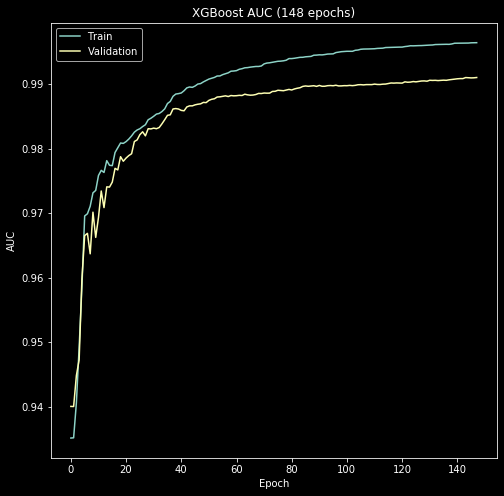

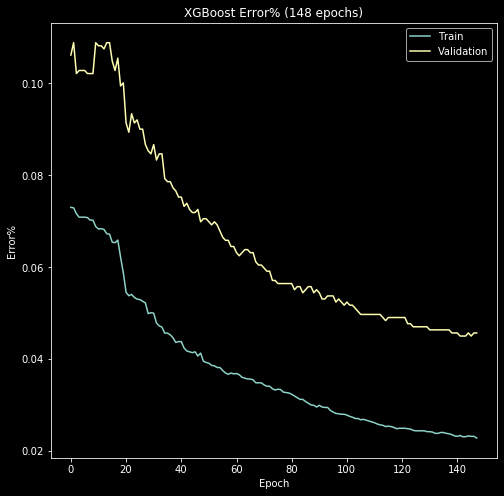

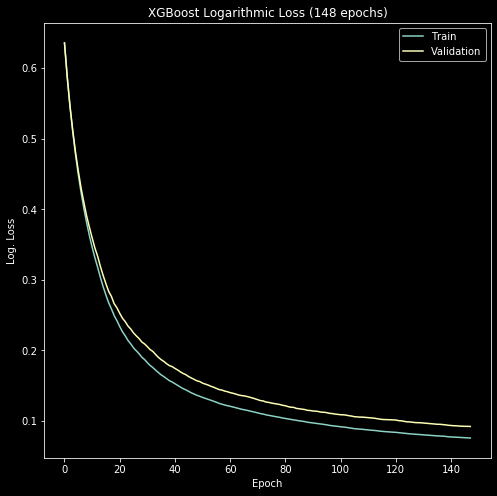

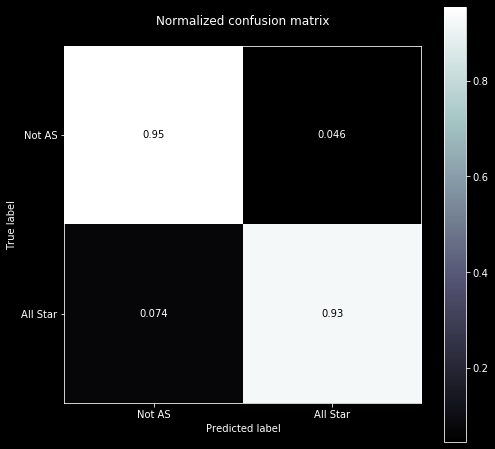

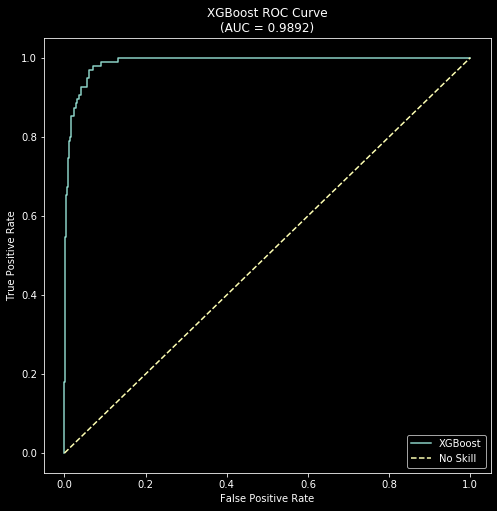

In [23]:
show_model_evaluations()

## Model Interpretation using SHAP Values

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


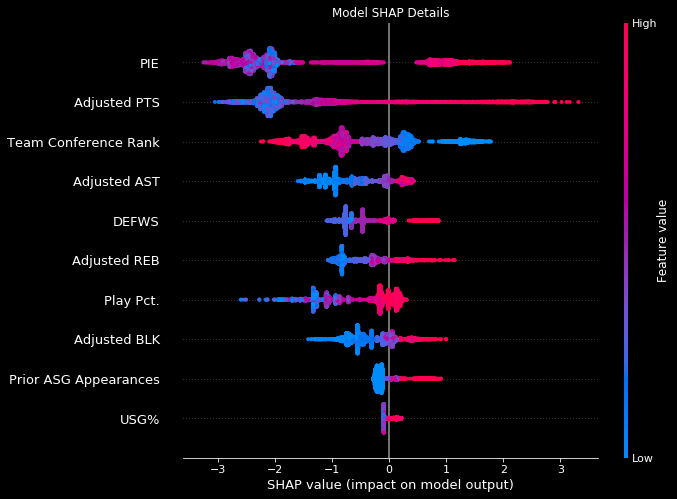

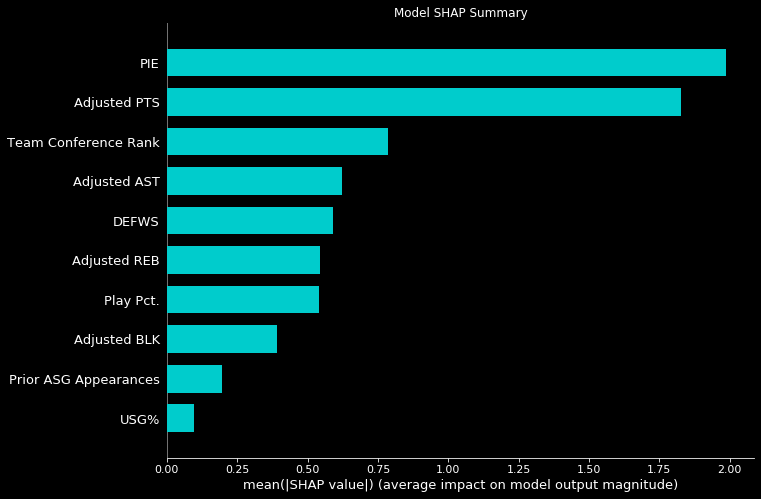

In [24]:
show_model_interpretation()

## Model Classification Metrics

In [25]:
show_classification_metrics()

,Score
Metric,
Accuracy,0.975151
Precision,0.784314
Recall,0.842105
F1 Score,0.812183
Log. Loss,0.103545
ROC AUC,0.989187


## Model Application to Current Players

In [26]:
# the following section applies the tuned model to all the active players in the current season
# the classifiction schema here takes the top 12 prediction probabilities from each
# conference, slightly different than our fixed threshold

df_to_predict['AS Prob.'] = [prob[1] for prob in tuned_model.predict_proba(df_to_predict)]
df_to_predict = df_to_predict.join(names_and_teams)[['PLAYER', 'TEAM', 'AS Prob.']]

eastern_conference = set(['ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DET', 'IND', 'MIA',
                          'MIL', 'NYK', 'ORL', 'PHI', 'TOR', 'WAS'])
df_to_predict['Conf.'] = df_to_predict['TEAM'].map(lambda x : 'East' if x in eastern_conference else 'West')

df_east = df_to_predict[df_to_predict['Conf.'] == 'East'].sort_values('AS Prob.', ascending=False).reset_index(drop=True)
df_west = df_to_predict[df_to_predict['Conf.'] == 'West'].sort_values('AS Prob.', ascending=False).reset_index(drop=True)

for df in [df_east, df_west]:
    df['Model Prediction'] = df.index.map(lambda x : 'Yes' if x < 12 else 'No')

df_east = df_east[['PLAYER', 'TEAM', 'Conf.', 'AS Prob.', 'Model Prediction']]
df_west = df_west[['PLAYER', 'TEAM', 'Conf.', 'AS Prob.', 'Model Prediction']]

summary_conf_size = 25

df_results_summary = pd.concat([df_east.head(summary_conf_size), df_west.head(summary_conf_size)]).set_index('PLAYER')
df_results_full = pd.concat([df_east, df_west]).set_index('PLAYER').sort_values('AS Prob.', ascending=False)

df_results_summary.to_csv('{}_NBA_ASG_predictor_results_summary.csv'.format(prediction_year))
df_results_full.to_csv('{}_NBA_ASG_predictor_results_full.csv'.format(prediction_year))

## Predictions for 2020 All-Star Game Selection

### Eastern Conference

In [27]:
df_east.head(summary_conf_size).set_index('PLAYER')

,TEAM,Conf.,AS Prob.,Model Prediction
PLAYER,,,,
Giannis Antetokounmpo,MIL,East,0.995914,Yes
Jimmy Butler,MIA,East,0.986528,Yes
Khris Middleton,MIL,East,0.972227,Yes
Jayson Tatum,BOS,East,0.966260,Yes
Kemba Walker,BOS,East,0.960982,Yes
Pascal Siakam,TOR,East,0.949431,Yes
Domantas Sabonis,IND,East,0.932390,Yes
Kyle Lowry,TOR,East,0.900801,Yes
Bam Adebayo,MIA,East,0.899604,Yes


### Western Conference

In [28]:
df_west.head(summary_conf_size).set_index('PLAYER')

,TEAM,Conf.,AS Prob.,Model Prediction
PLAYER,,,,
Anthony Davis,LAL,West,0.995695,Yes
LeBron James,LAL,West,0.995578,Yes
James Harden,HOU,West,0.992265,Yes
Damian Lillard,POR,West,0.983652,Yes
Kawhi Leonard,LAC,West,0.981010,Yes
Russell Westbrook,HOU,West,0.976483,Yes
Luka Doncic,DAL,West,0.970403,Yes
Nikola Jokic,DEN,West,0.970189,Yes
Donovan Mitchell,UTA,West,0.964947,Yes
